# **Question Fomulation & Data Analysis**

In [1]:
import math
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## **Q1: Liệu age ảnh hưởng đến điểm G3 khác nhau giữa nam và nữ không?**

### **Motivation & Benefits:**
**Why is this question worth investigating?**
- Tuổi tác có thể liên quan đến mức độ trưởng thành, khả năng học tập và áp lực học tập.

**What benefits or insights would answering this question provide?**
- Giúp giáo viên và nhà trường xác định nhóm học sinh cần hỗ trợ đặc biệt (ví dụ, nam học sinh lớn tuổi có thể gặp khó khăn hơn)
- Cho phép lập kế hoạch giáo dục cá nhân hóa, mentoring hoặc hướng dẫn thêm cho nhóm học sinh rủi ro cao

**Who would care about the answer?**
- Giáo viên, cố vấn học tập, ban giám hiệu 
- Phụ huynh quan tâm đến tiến độ học tập của con.

**What real-world problem or decision does this inform?**
- Quyết định phân bổ nguồn lực hỗ trợ học tập: dạy kèm, mentoring, tư vấn nhóm.
- Đưa ra chính sách giảng dạy phù hợp với từng nhóm tuổi và giới tính.

### **A. Preprocessing**

- Chuyển đổi kiểu dữ liệu sex sang category
- Lọc dữ liệu theo tuổi hợp lý age
- Kiểm tra thống kê mô tả cơ bản age, sex, G3
- Tổng hợp điểm trung bình G3 theo tuổi và giới tính

In [2]:
df = pd.read_csv('../data/raw/student-combine.csv')

In [3]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [4]:
df['sex'] = df['sex'].astype('category')
df = df[(df['age'] >= 15) & (df['age'] <= 22)]
print(df[['age','sex','G3']].describe())

               age           G3
count  1044.000000  1044.000000
mean     16.726054    11.341954
std       1.239975     3.864796
min      15.000000     0.000000
25%      16.000000    10.000000
50%      17.000000    11.000000
75%      18.000000    14.000000
max      22.000000    20.000000


In [5]:
age_sex_summary = df.groupby(['age','sex'])['G3'].mean().reset_index()
print(age_sex_summary)

    age sex         G3
0    15   F  11.021053
1    15   M  12.444444
2    16   F  11.779874
3    16   M  11.450820
4    17   F  12.070175
5    17   M  10.745283
6    18   F  11.125984
7    18   M  10.715789
8    19   F   8.939394
9    19   M   9.000000
10   20   F  12.400000
11   20   M  13.000000
12   21   F  12.000000
13   21   M   8.500000
14   22   F        NaN
15   22   M   6.500000


C:\Users\vnviv\AppData\Local\Temp\ipykernel_16584\3235330407.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sex_summary = df.groupby(['age','sex'])['G3'].mean().reset_index()


### **B. Analysis**
**Scatter Plot:**
- Mục đích: 
    - Hiển thị các điểm dữ liệu riêng lẻ (G3 theo age), phân biệt theo giới tính
    - Cho phép trực quan hóa sự phân tán, điểm outlier, và mối quan hệ thô giữa tuổi và điểm số cho từng nhóm nam/nữ

**Line Plot:**
- Mục đích: 
    - Vẽ trend trung bình điểm G3 theo từng tuổi, tách theo giới tính
    - Giúp thấy xu hướng tổng thể và sự khác biệt giữa nam và nữ theo tuổi, thay vì chỉ nhìn từng điểm rời rạc

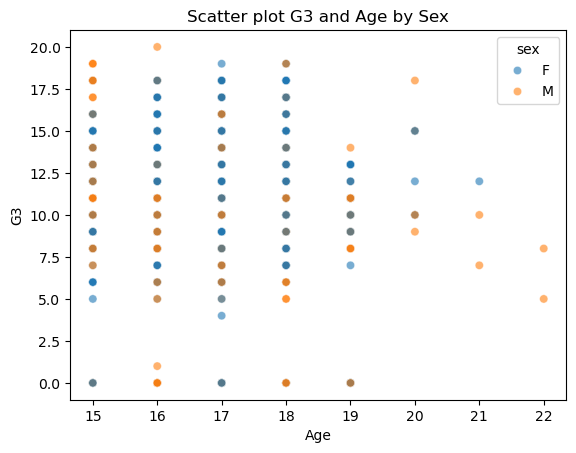

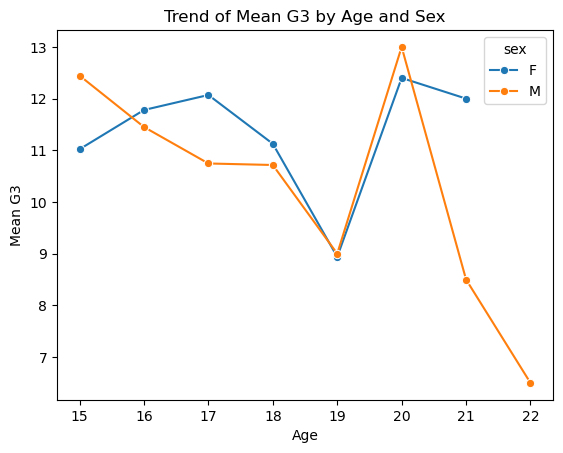

In [6]:
sns.scatterplot(data=df, x='age', y='G3', hue='sex', alpha=0.6)
plt.title('Scatter plot G3 and Age by Sex')
plt.xlabel('Age')
plt.ylabel('G3')
plt.show()

sns.lineplot(data=age_sex_summary, x='age', y='G3', hue='sex', marker='o')
plt.title('Trend of Mean G3 by Age and Sex')
plt.xlabel('Age')
plt.ylabel('Mean G3')
plt.show()

**Nhận xét:**
- Nam học sinh tuổi 21–22 có G3 giảm mạnh 
- Nữ có trend ổn định hơn, điểm trung bình ít biến động

**Ý nghĩa:**
- Học sinh nam lớn tuổi hơn (21–22) có nguy cơ rớt môn cao hơn, cần sự hỗ trợ học tập và mentoring đặc biệt
- Nhà trường có thể lập kế hoạch tư vấn, dạy kèm hoặc can thiệp sớm cho nhóm nam lớn tuổi để giảm tỷ lệ rớt môn

**Hạn chế**
- Số học sinh ở các tuổi lớn (21–22) có thể ít, dẫn đến điểm trung bình dao động mạnh.
- Dữ liệu chỉ tính trung bình, không phản ánh phân phối từng học sinh.
- Phân tích chưa kiểm định thống kê inferential (ví dụ t-test hay ANOVA) để xác nhận sự khác biệt có ý nghĩa

## **Q2: Dự đoán học sinh có nguy cơ rớt môn dựa trên các yếu tố hành vi  (romantic, goout, Dalc, Walc, health, freetime) và G1,G2**

### **Motivation & Benefits:**
**Why is this question worth investigating?**
- Học sinh rớt môn là vấn đề phổ biến, ảnh hưởng đến tiến độ học tập và tâm lý học sinh.
- Việc dự đoán sớm giúp can thiệp kịp thời, trước khi kết quả học tập trở nên xấu đi

**What benefits or insights would answering this question provide?**
- Xác định các yếu tố hành vi ảnh hưởng mạnh đến nguy cơ rớt môn.
- Hỗ trợ thiết kế các chương trình hỗ trợ học tập, tư vấn tâm lý, quản lý thời gian và thói quen sinh hoạt học sinh.

**Who would care about the answer?**
- Giáo viên, cố vấn học tập, ban giám hiệu

**What real-world problem or decision does this inform?**
- Quyết định ai cần được tư vấn, mentoring hoặc hỗ trợ thêm.
- Phát triển hệ thống cảnh báo sớm để giảm tỷ lệ học sinh rớt môn.

### **A. Preprocessing**

- Chọn các biến liên quan
- Mã hóa biến categorical romantic: 0 - không có romantic, 1 - có romantic
- Tạo nhãn dự đoán
- Chia dữ liệu train/test
- Scale dữ liệu

In [7]:
risk_of_fail = df[['romantic', 'goout', 'Dalc', 'Walc', 'health', 'freetime','G1','G2']]
risk_of_fail['romantic'] = risk_of_fail['romantic'].map({'yes': 1, 'no': 0})
label_risk = (df['G3'] < 10).astype(int)

C:\Users\vnviv\AppData\Local\Temp\ipykernel_16584\2953468566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_of_fail['romantic'] = risk_of_fail['romantic'].map({'yes': 1, 'no': 0})


In [8]:
label_risk.value_counts()

G3
0    814
1    230
Name: count, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    risk_of_fail, 
    label_risk, 
    test_size=0.2, 
    random_state=42,
    stratify = label_risk
)

In [10]:
scaler = StandardScaler()

# Scale lại input
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **B. Analysis**
**Logistic Regression:**
- Chọn Logistic Regression vì đây là bài toán classification nhị phân
- Mô hình đơn giản, dễ giải thích, có thể cung cấp xác suất dự đoán.
- Thích hợp làm baseline model trước khi thử các model phức tạp hơn.

**Support Vector Classifier (SVC):**
- Sử dụng kernel RBF để model có thể học các ranh giới phân lớp không tuyến tính.
- SVC thường có hiệu suất tốt với dữ liệu có số chiều vừa phải và có thể bắt được pattern phức tạp hơn Logistic Regression.

**Evaluation Metrics:**
- Accuracy: Đánh giá tổng thể mức độ dự đoán đúng.
- Confusion Matrix: Quan sát số lượng học sinh dự đoán đúng/sai theo lớp Low Risk / High Risk.
- Classification Report: Bao gồm precision, recall, f1-score → giúp hiểu rõ hiệu suất từng lớp, quan trọng khi dữ liệu mất cân bằng.

**Workflow Logic:**
- Dữ liệu đã được preprocessing và scale (StandardScaler) để đảm bảo mô hình hoạt động ổn định.
- Train model trên X_train_scaled và test trên X_test_scaled.
- Đánh giá kết quả bằng accuracy, confusion matrix và classification report.
- So sánh hiệu quả giữa Logistic Regression (linear, dễ giải thích) và SVC (non-linear, mạnh hơn).

In [11]:
model  = LogisticRegression(
    solver = 'sag',
    max_iter=100,
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)
print("Train accuracy:", accuracy_score(y_train, y_pred))
y_pred_test = model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

Train accuracy: 0.9233532934131736
Test accuracy: 0.9186602870813397


Text(0.5, 427.9555555555555, 'Predicted label')

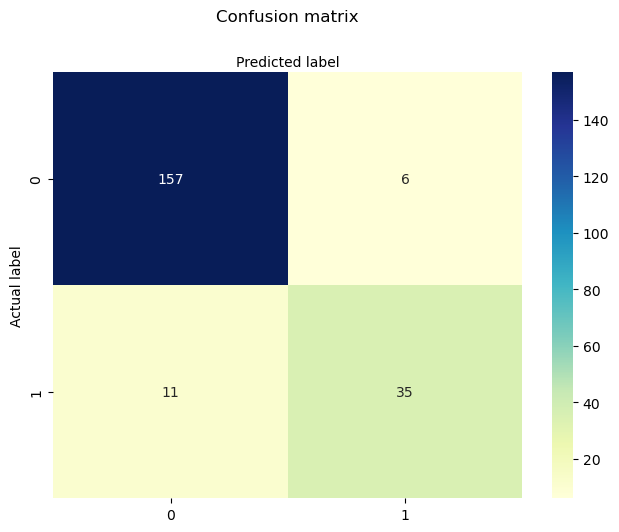

In [12]:
cnf_matrix = confusion_matrix(y_test, y_pred_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [13]:
print(classification_report(y_test, y_pred_test, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.93      0.96      0.95       163
   High Risk       0.85      0.76      0.80        46

    accuracy                           0.92       209
   macro avg       0.89      0.86      0.88       209
weighted avg       0.92      0.92      0.92       209



In [14]:
model_svc = SVC(
    kernel='rbf',    
    random_state=42
)
model_svc.fit(X_train_scaled, y_train)
# Train
y_pred_train = model_svc.predict(X_train_scaled)
print("Train accuracy:", accuracy_score(y_train, y_pred_train))

# Test
y_pred_test = model_svc.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_test))


Train accuracy: 0.9293413173652695
Test accuracy: 0.9043062200956937


Text(0.5, 427.9555555555555, 'Predicted label')

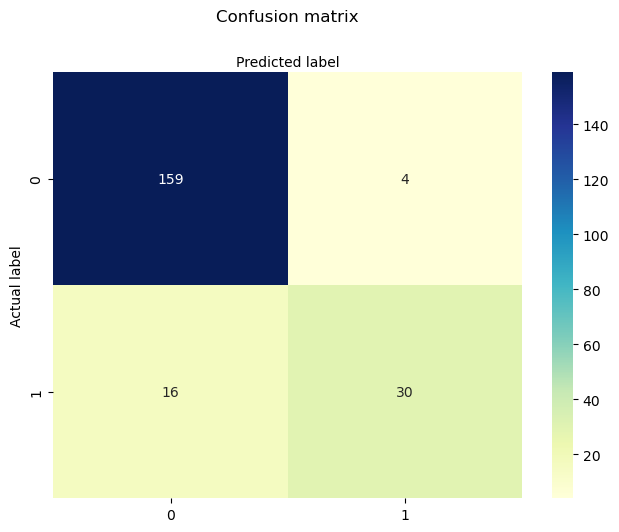

In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred_test)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
print(classification_report(y_test, y_pred_test, target_names=['Low Risk', 'High Risk']))

              precision    recall  f1-score   support

    Low Risk       0.91      0.98      0.94       163
   High Risk       0.88      0.65      0.75        46

    accuracy                           0.90       209
   macro avg       0.90      0.81      0.85       209
weighted avg       0.90      0.90      0.90       209



## **Q1: Các yếu tố về gia đình (như `famsize`, `Medu`, `Fedu`, ...) có ảnh hưởng đến kết quả học tập của một học sinh hay không?**

### **The question**
- Tập trung vào mối quan hệ giữa các biến độc lập thuộc nhóm gia đình (`famsize`, `Pstatus`, `Medu`,...) và biến Target là điểm số cuối kì `G3`

### **Motivation and Benefits**
**Why is this question worth investigating?**

Gia đình là môi trường giáo dục đầu tiên, có ảnh hưởng lớn để sự phát triển của trẻ vị thành niên. Việc xác định những yếu tố về gia đình như tình trạng gia đình, trình độ học vấn của ba mẹ, mối quan hệ của học sinh với gia đình có phải là những yếu tố dựa đoán mạnh mẽ rằng học sinh sẽ học tập tốt hơn hay không.

**What benefits or insights would be answering this question provide?**

- Học vấn của mẹ (Medu) hay của bố (Fedu) có ảnh hưởng lớn hơn đến kết quả học tập của con cái.
    
**Who would care about the answer?**
- Giáo viên, hiệu trưởng: để hiểu rõ hoàn cảnh của học sinh và từ đó có cái nhìn khách quan hơn, và có các phương pháp tiếp cận phù hợp.
- Bộ giáo dục: có các chính sách để bổ trợ cho các nhóm học sinh yếu thế.

**What real-world problem or decision does this inform?** 

Kết quả phân tích giúp ta xây dựng được các chương trình **Can thiệp sớm**. Thay vì đợi học sinh học yếu đi thì mới hỗ trợ hay chỉ hỗ trợ những học sinh nghèo vượt khó. Ta còn có thể dựa vào các yếu tố về gia đình có thể xác định các học sinh vào nhóm có *nguy cơ cao* ngay từ đầu năm học để cung cấp và hỗ trợ về cố vấn học tập hay tài chính kịp thời.

### **A. Preprocessing**
Các bước preprocessing:

1. **Data Preparation**: Trích xuất các đặc trưng có liên quan đến gia đình của học sinh $\rightarrow$ dùng để phân tích

2. **Feature Engineering**: Tạo đặc trưng `parent_edu`: Gồm trung cộng của `Medu` và `Fedu`
    
3. **Data Cleaning**: Gom nhóm dữ liệu `Medu` và `Fedu` do `Medu = 0` và `Fedu = 0` có số lượng quá ít (không có giá trị thực tiễn) $\rightarrow$ gom nhóm dữ liệu với ` Fedu || Medu = 1`

In [17]:
df = pd.read_csv("../data/processed/student-clean.csv")

In [18]:
# Chuẩn bị data cho câu hỏi liên quan
fam_features = ["famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "famsup", "famrel", "parent_edu"]

ordinal_features = ["Medu", "Fedu", "famrel", "parent_edu"]

cat_features = [f for f in fam_features if f not in ordinal_features]

# Tạo dataframe chỉ gồm các yếu tố liên quan đến gia đình
df_fam = df[[f"{f}" for f in fam_features]].copy()

# Thêm cột target và dataframe
df_fam['G3'] = df['G3']

In [19]:
# Gộp các giá trị Medu và Fedu = 0 vào mức 1 
df_fam['Medu'] = df_fam['Medu'].replace(0, 1)
df_fam['Fedu'] = df_fam['Fedu'].replace(0, 1)

# Do đã cập nhật nên sẽ liên quan đến biến parent_edu
df_fam['parent_edu'] = (df_fam['Medu'] + df_fam['Fedu']) / 2

### **B. Analysis**

1. **Visualization**: sử dụng **Boxplot** vẽ các cột categorical (so sánh sự phân tán của các cột). Đối với các cột Numerical sẽ vẽ thêm đường trung bình trong **Boxplot**. Và sau cùng là vẽ **Heatmap** để so sánh độ tương quan tổng thể của các biến Numerical (bao gồm cả biến target)

2. **Kiểm định thống kê**: để xác thực các quan sát rút ra từ biểu đồ, sử dụng kiểm định **T-test** (cho các cột có biến nhị phân) và **ANOVA** (cho các cột có nhiều biến) với ngưỡng tin cậy là 95%

Boxplot cho các biến categorical

In [20]:
def plot_cat_grid(df, cat_cols, target = 'G3', n_cols = 3):
    """
    Vẽ grid các boxplot cho các biến categorical
    """
    
    n_vars = len(cat_cols)
    n_rows = math.ceil(n_vars / n_cols)
    
    fig, axes  = plt.subplots(n_rows, n_cols, figsize= (n_cols*5, n_rows*5))
    
    axes = axes.flatten()
    
    for i, col in enumerate(cat_cols):
        
        sns.boxplot(x = col, y = target, data= df, palette="Set2", hue=col, legend=False, ax = axes[i])
        
        axes[i].set_title(f"Tác động của {col} đến biến {target}")
        axes[i].set_xlabel('')
        axes[i].set_ylabel(target)
        
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
            
    plt.tight_layout()
    plt.show()

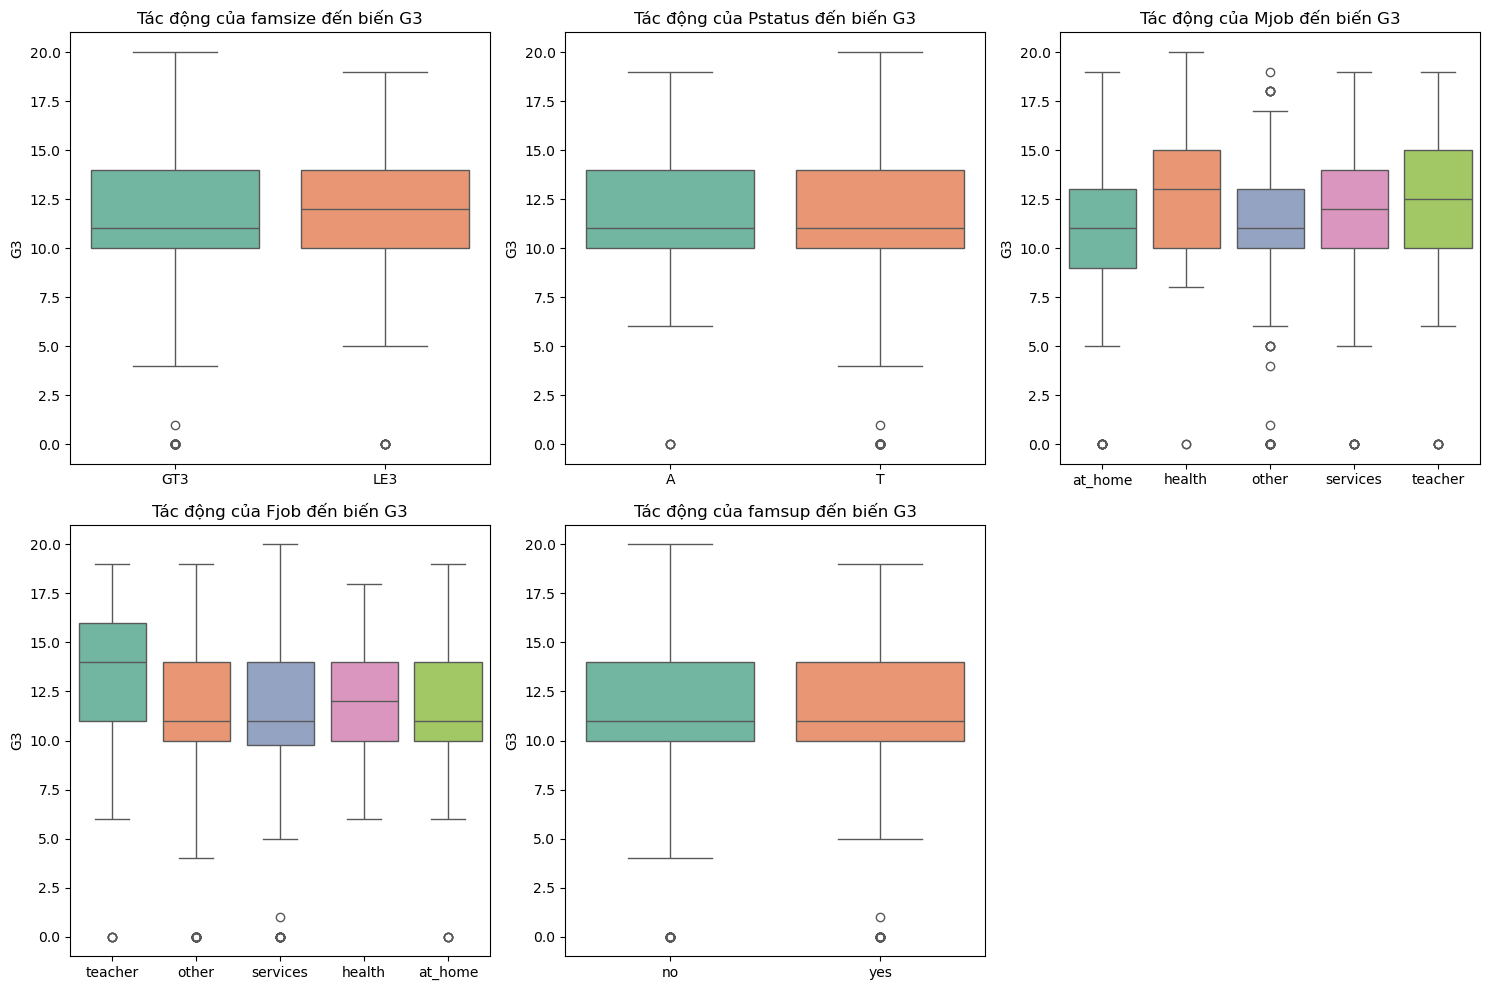

In [21]:
plot_cat_grid(df_fam, cat_features)

Vẽ Line Plot cho các biến Numerical

In [22]:
def plot_line_grid(df, ordinal_cols, target = 'G3', n_cols = 3):      
    n_vars = len(ordinal_cols)
    n_rows = math.ceil(n_vars / n_cols)
    
    fig, axes  = plt.subplots(n_rows, n_cols, figsize= (n_cols*5, n_rows*5))
    
    axes = axes.flatten()
    
    for i, col in enumerate(ordinal_cols):
        sns.lineplot(x=col, y=target, data=df, ax=axes[i], 
                     marker='o', color='red', linewidth=2.5)
        
        axes[i].set_title(f"Tác động của {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel("G3")
        
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

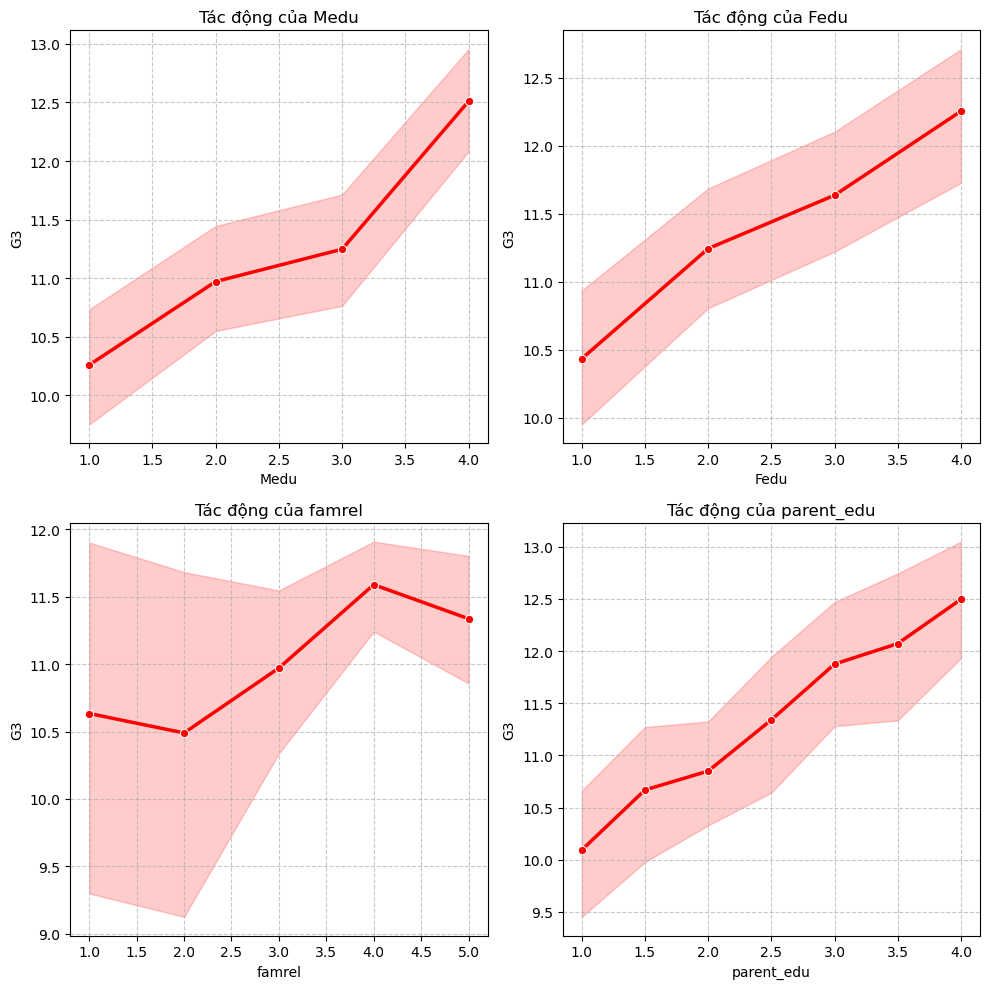

In [23]:
plot_line_grid(df_fam, ordinal_features, n_cols=2)

#### **Thực hiện lại bằng T-test/ANOVA**

In [24]:
def statistical_testing(df, cat_col, target = 'G3'):
    """
    Hàm kiểm tra dùng T-test hoặc ANOVA dự trên số nhóm
    """
    print("-" * 20)
    groups = df.groupby(cat_col)[target].apply(list)
    
    if len(groups) == 2:
        stat, p_value = stats.ttest_ind(groups.iloc[0], groups.iloc[1])
        test_type = "T-test"
        
    else:
        stat, p_value = stats.f_oneway(*groups)
        test_type = "ANOVA"
        
    print(f"\nKiểm định cột {cat_col}")
    print(f"Loại test: {test_type}")
    print(f"P-value: {p_value:3f}")
        
    if p_value < 0.05:
        print(f"Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)\n")
        return 1
    else:
        print(f"Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)\n")
        return 0

In [25]:
# Kiểm tra các biến bằng T-test và ANOVA
affect_features = []
for cat in fam_features:
    if(statistical_testing(df_fam, cat)):
        affect_features.append(cat)

print(affect_features)

--------------------

Kiểm định cột famsize
Loại test: T-test
P-value: 0.048020
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Pstatus
Loại test: T-test
P-value: 0.321797
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột Medu
Loại test: ANOVA
P-value: 0.000000
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fedu
Loại test: ANOVA
P-value: 0.000002
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Mjob
Loại test: ANOVA
P-value: 0.000003
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột Fjob
Loại test: ANOVA
P-value: 0.009036
Có sự ảnh hưởng (Sự khác biệt có ý nghĩa thống kê)

--------------------

Kiểm định cột famsup
Loại test: T-test
P-value: 0.667452
Không ảnh hưởng (Sự khác biệt chỉ là ngẫu nhiên)

--------------------

Kiểm định cột famrel
Loại test: ANOVA
P-value: 0.139367
Không ảnh hưởng (Sự

### **C. Results & Interpretation**

#### **Kết quả nghiên cứu**  

Dựa vào các kết quả phân tích trực quan và kiểm định thống kê, ta có thể khẳng định rằng trong tập dataset này các yếu tố gia đình có ảnh hưởng đáng kể đến kết quả học tập của học sinh. Nhưng các yếu tố ảnh hưởng không đồng đều:  

- Ảnh hưởng mạnh nhất: Nhóm về nền tảng tri thức `parent_edu` (hay `Medu` và `Fedu`) và nghề nghiệp (`Fjob`, `Mjob`). 

- Ảnh hưởng tầm trung: Quy mô của gia đình (`famsize`).  

- Các cột còn lại không có ảnh hưởng đáng kể đến kết quả điểm số của học sinh.  

#### **Phân tích chi tiết**  

**1. Tác động của nền tảng tri thức (`parent_edu`)**  
Dựa vào biểu đồ Boxplot và kiểm định ANOVA (p_value = 0.05) ta thấy có 1 xu hướng rõ rệt là, trình độ học vấn của cha mẹ càng cao thì điểm trung bình của con họ càng cao theo.

- Dẫn chứng: Ta thấy khi `parent_edu = 3.5 hay 4.0` thì điểm trung vị đạt khoảng 12.5 điểm, cao hơn đáng kể so với nhóm học sinh có cha mẹ học thấp hơn.

- Ý nghĩa: Điều này cho ta thấy nền tảng tri thức có ảnh hưởng rất nhiều đến nhận thức và là nền tảng cho học sinh có khả năng và phương pháp học tập tốt hơn.

**2. Tác động của nghề nghiệp (`Mjob`, `Fjob`)**  
Nghề nghiệp còn phản ánh môi trường tri thức, thói quen tại gia đình

- Dẫn chứng: Các học sinh có bậc cha mẹ làm giáo viên (`teacher`) hoặc làm trong khối ngành sức khoẻ (`health`) có mức điểm vượt trội hơn các nhóm còn lại.

- Ý nghĩa: Sự chênh lệch này gợi ý rằng sự ổn định về kinh tế và môi trường khuyến học tạo ra lợi thế cạnh tranh lớn cho học sinh.

**3. Tác động quy mô gia đình (`famsize`)**   
Mặc dù nhìn vào Boxplot thấy sự chênh lệch các giá trị không quá lớn, nhưng sau khi kiểm định T-test đã xác định được sự khác biệt về mặc thống kê

- Dẫn chứng: Học sinh có gia đình quy mô nhỏ thì điểm sẽ ổn định hơn các gia đình có quy mô lớn.

- Ý nghĩa: Điều này rất phù hợp với giả thuyết rằng ở một gia đình ít con hơn thì vấn đề tiền bạc hay sự quan tâm đều chất lượng hơn nhiều so với gia đình có đông con (bị chia nhỏ ra nên ít có sự quan tâm hơn)

#### **Những phát hiện trong phân tích dữ liệu**

**Nghịch lý trong `famsup`**  
Một điều trái với những suy đoán thông thường (nếu được gia đình ủng hộ nhiều trong việc học tập thì điểm số của học sinh sẽ tốt hơn) nhưng ở đây dù cho có được ủng hộ hay không thì cũng không tạo ra được sự khác biệt về điểm số của 2 nhóm đó.

- Phân tích: Cả 2 nhóm "Được hỗ trợ" và "Không được hỗ trợ" đều có trung vị tương đương với nhau.

- Ý nghĩa: Việc nhóm học sinh "Không được hỗ trợ" có trung vị ngang với nhóm còn lại chứng tỏ việc các em học sinh nhận thức được việc cần phải tự cố gắng học tập cho nên điểm trung vị của 2 bên là xấp xỉ nhau.

#### **Limitations**
- Tương quan không phải Nhân quả: Việc con giáo viên học giỏi có thể do gen di truyền hoặc môi trường, không chắc chắn 100% là do nghề nghiệp quyết định.


## **Q2: Dựa vào các thói quen của học sinh có thể dự đoán họ có trở nên uống rượu nhiều hơn hay không? (sử dụng Machine Learning)**

### **The question**
- Dữ liệu sử dụng sẽ tập trung vào các biến hành vi (thói quen) của học sinh như `goout`, `freetime`,... để sự đoán về biến mục tiêu `Walc` rằng học sinh đó sẽ được phân loại vô nhóm uống nhiều hay uống ít.

### **Motivation and Benefits**
**Why is this question worth investigating?**  

Ta tập trung vào những yếu tố có thể khắc phục, trái với các yếu tố gia đình thì thói quen ta có thể can thiệp và điều chỉnh sao cho hợp lí. Và một phần cũng giúp kiểm chứng được tác động của những thói quen đó có làm cho một người uống rượu nhiều hơn hay không.

**What benefits or insights would be answering this question provide?**
- Xác định được những thói quen độc hại nào sẽ có nguy cơ gây uống rượu cao ở học sinh.
- Dự báo sớm dự trên các hành vi, chỉ cần quan sát trong quá trình sinh hoạt, thói quen có thể dự báo được nguy cơ.

**Who would care about the answer?**
- Phụ huynh: Để họ hiểu rằng các thói quen sinh hoạt cũng rất quan trọng chứ không chỉ là có điểm số.
- Giáo viên, tư vấn viên: Họ có cơ sở để phát hiện các học sinh có nguy cơ uống rượu cao và từ đó có các cách can thiệp sớm kịp thời.

**What real-world problem or decision does this inform?**  

Giúp nhà trường, phụ huynh phát hiện sớm hành vi để có thể can thiệp kịp thời, tránh những hành vi sa ngã quá mức. Ngoài ra còn có thể thiết kế các chương trình giáo dục kĩ năng, giúp điều chỉnh thói quen hoặc nâng cao nhận thức của học sinh ngay từ sớm để ngăn chặn nguy cơ.

### **A. Preprocessing**
Các bước preprocessing:
- Trích xuất các feature về thói quen của học sinh gồm (`studytime`, `activities`, `internet`, `romantic`, `freetime`, `goout`, `Walc`)

- Encoding: các biến binary categorical (`yes = 1` và `no = 0`)

- Feature Engineering: biến target `is_high_risk` nếu `Walc > 2` $\rightarrow$ `is_high_risk = 1`


In [155]:
df = pd.read_csv("../data/processed/student-clean.csv")

In [156]:
habit_features = ["studytime", "activities", "internet", "romantic", "freetime", "goout"]

df_habit = df[habit_features].copy()
df_habit['Walc'] = df['Walc'].copy()

In [157]:
# Encoding các biến categorical
mapping_binary = {
    'yes' : 1,
    'no' : 0,
}

binary_features = ["activities", "internet", "romantic"]
for f in binary_features:
    df_habit[f] = df_habit[f].map(mapping_binary)

### **B. Analysis**

- **Colleration heatmap**: Xem có mối liên quan giữa các biến thói quen với biến target (`Walc`), biến nào ảnh hưởng nhiều, ảnh hưởng ít $\rightarrow$ chú ý đặc biệt hơn đến những điều đó.

- **Kiểm tra độ cân bằng của target**: Xem các giá trị của biến target có bị mất cân bằng hay không $\rightarrow$ có hướng đi phù hợp để xử lý cân bằng.

- **Lựa chọn mô hình**:
    - Logistic Regression: Có khả năng phân tích các biến (do có cung cấp hệ số `Coeficients` cho từng biến); Phù hợp với dữ liệu nhỏ ít bị Overfitting nhanh gọn và hiệu quả.
    
    - Random Forest: Có khả năng nắm bắt quan hệ phi tuyến tính phức tạp; Đây là mô hình tổ hợp nhiều câu quyết định nên thường có độ chính xác cao và ổn định hơn; Có thể tính độ quan trọng của biến (Feature Importance).

- **Metric Evaluation**: Dùng Accuracy, Confusion Matrix và Classification report để lựa chọn mô hình tối ưu.

#### **Vẽ Colleration Heatmap của các biến**

In [158]:
def plot_correlation_heatmap(df, num_cols):
    """
    Vẽ heatmap các biến Numerical (Ordinal) 
    """
    
    corr_matrix = df[num_cols].corr(method='spearman')
    
    plt.figure(figsize=(12,10))
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix,
                mask= mask,
                annot = True,
                fmt = ".2f",
                cmap = "coolwarm",
                vmin=-1, vmax=1,
                center=0,
                linewidths=0.5,
                cbar_kws={"shrink" : .8})
    
    plt.title(f"Biểu đồ tương quan của các biến cột Numerical (Ordinal)")
    plt.show()

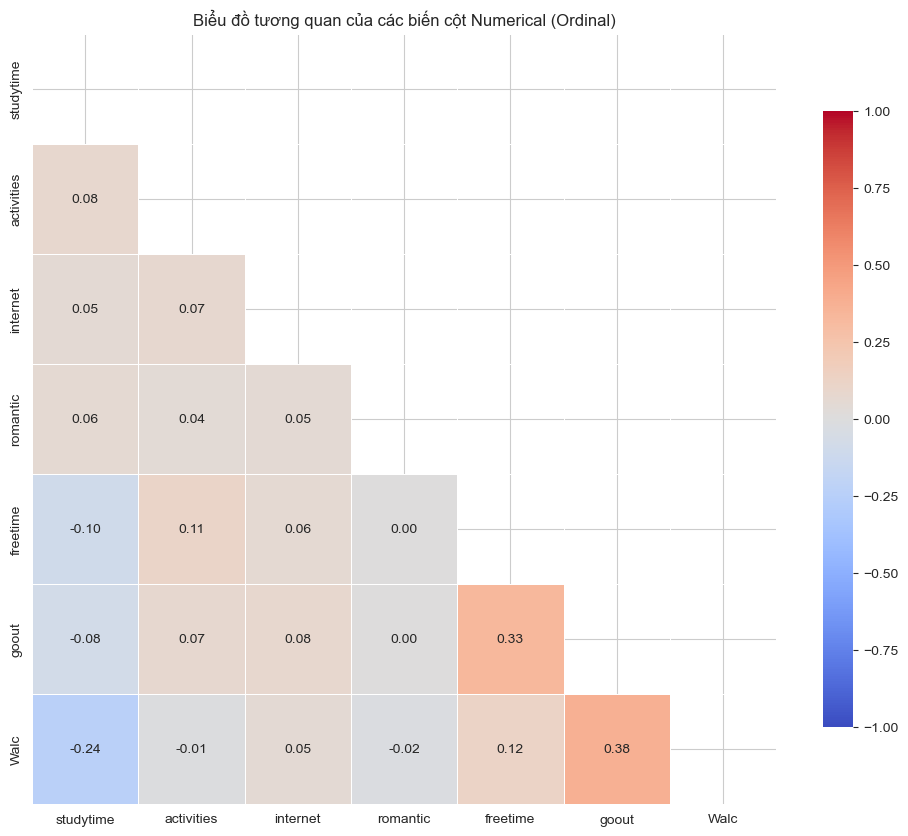

In [159]:
habit_target_features = habit_features + ["Walc"]

plot_correlation_heatmap(df_habit, habit_target_features)

In [160]:
df_habit['free_go'] = df_habit['freetime'] * df_habit['goout']

df_habit.drop(labels=['freetime', 'goout'], axis=1, inplace=True)

**Nhận xét:** 
- Nhóm có độ tương quan cao với biến `Walc`: `goout` (tương quan thuận), `studytime` (tương quan nghịch) $\rightarrow$ Điều đó cho thấy việc càng dành nhiều thời gian để đi chơi sẽ khiến học sinh càng uống rượu nhiều hơn và với việc dành nhiều thời gian để học tương đương với việc uống ít rượu hơn.

- Các nhóm còn lại có tác động không đáng kể.

#### **Kiểm tra biến Target**

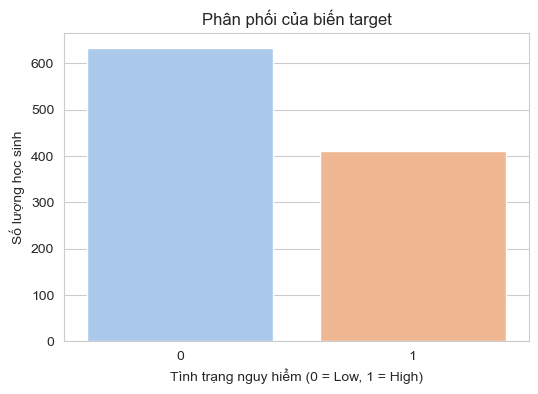

In [161]:
# Tạo cột binary cateogircal với ngưỡng > 2 -> uống nhiều
df_habit['is_high_risk'] = (df_habit['Walc'] > 2).astype(int)

# Visualization
plt.figure(figsize=(6,4))

sns.countplot(data = df_habit, x = 'is_high_risk', palette='pastel', hue = 'is_high_risk', legend=False)

plt.title("Phân phối của biến target")
plt.xlabel("Tình trạng nguy hiểm (0 = Low, 1 = High)")
plt.ylabel("Số lượng học sinh")
plt.show()

**Nhận xét**: Biến target bị mất cân bằng dữ liệu nhẹ (khoảng 60%/40%)

#### **Sử dụng Machine Learning để dự đoán**

In [162]:
# Chuẩn bị dữ liệu train
target_col = 'is_high_risk'

y = df_habit[target_col].copy()

df_habit.drop(labels=['Walc', 'is_high_risk'], axis=1, inplace=True)
X = df_habit[df_habit.columns].copy()


In [163]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 33)

In [164]:
scaler = StandardScaler()

# Scale lại input
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [165]:
def evalutate_model(model_name, y_true, y_pred):
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification report: \n{classification_report(y_true, y_pred)}")

In [166]:
def confusion_matrix_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Low Risk (0)', 'High Risk (1)'],
                yticklabels=['Low Risk (0)', 'High Risk (1)'])

    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

**Sử dụng Logistic Regression**

In [183]:
# Logistic Regression với class_weight
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=33)

lr_model.fit(X_train_scaled, y_train)
y_prob = lr_model.predict_proba(X_test_scaled)[:, 1] # Lấy cột xác suất của lớp 1

threshold = 0.35
y_pred_lr = (y_prob >= threshold).astype(int)

evalutate_model("Logistis Regression with class_weight", y_test, y_pred_lr)

Model: Logistis Regression with class_weight
Accuracy: 0.62
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.45      0.59       128
           1       0.51      0.90      0.65        81

    accuracy                           0.62       209
   macro avg       0.69      0.67      0.62       209
weighted avg       0.73      0.62      0.61       209



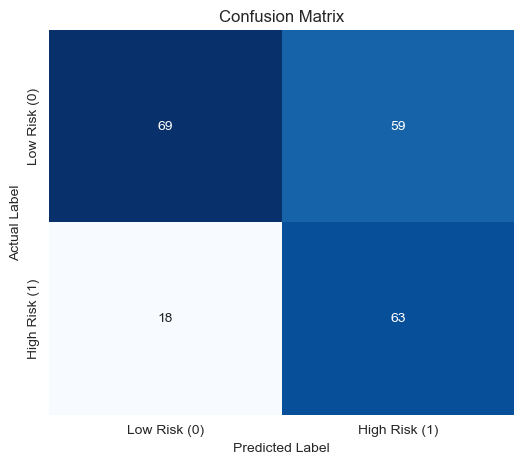

In [173]:
confusion_matrix_plot(y_test, y_pred_lr)

**Sử dụng Random Forest**

In [184]:
# RandomForest với clas_weight
rf_model = RandomForestClassifier(class_weight='balanced', random_state=33, n_estimators=100)

rf_model.fit(X_train, y_train)
y_prob = rf_model.predict_proba(X_test)[:, 1]

threshold = 0.35
y_pred_rf = (y_prob >= threshold).astype(int)

evalutate_model("Random Forest with class_weight", y_test, y_pred_rf)

Model: Random Forest with class_weight
Accuracy: 0.64
Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       128
           1       0.53      0.78      0.63        81

    accuracy                           0.64       209
   macro avg       0.66      0.67      0.64       209
weighted avg       0.69      0.64      0.64       209



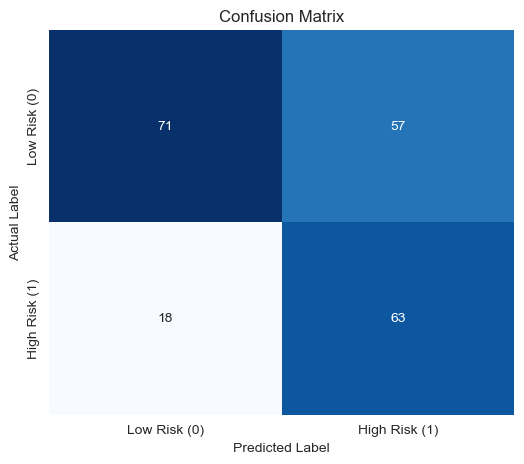

In [185]:
confusion_matrix_plot(y_test, y_pred_rf)

#### **Feature Interpretation**

        Habit  Coefficient  Absolute_Impact
4     free_go     0.722011         0.722011
0   studytime    -0.342013         0.342013
1  activities    -0.077770         0.077770
2    internet     0.072451         0.072451
3    romantic     0.003456         0.003456


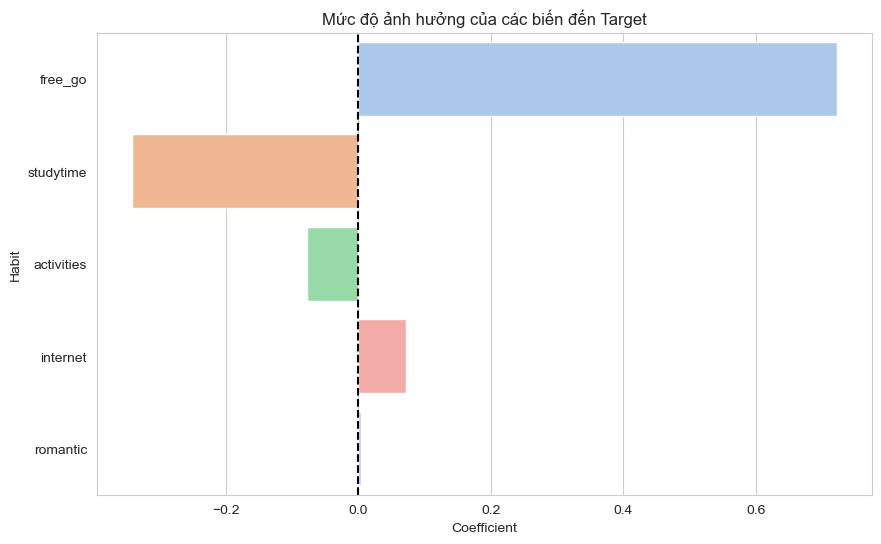

In [186]:
feature_names = X_train.columns

# Lấy hệ số (coefficients) từ model Logistic Regression
coefficients = lr_model.coef_[0]

feature_importance = pd.DataFrame({
    'Habit': feature_names,
    'Coefficient': coefficients,
    'Absolute_Impact': abs(coefficients) # Lấy trị tuyệt đối 
})

# Sắp xếp theo mức độ ảnh hưởng giảm dần
feature_importance = feature_importance.sort_values(by='Absolute_Impact', ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Habit', data=feature_importance, palette='pastel', hue = 'Habit', legend=False)
plt.title('Mức độ ảnh hưởng của các biến đến Target')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

### **C. Results & Interpretation**

#### **Model performance & Selection**
Sau khi thực hiện 2 mô hình, ta có kết quả như sau:
- Logistic Regression: Recall (90%) đối với nhóm `is_high_risk = 1` và Precision (51%)
- Random Forest: Recall (78%) đối với nhóm `is_high_risk = 1` và Precision (53%)

$\Rightarrow$ Quyết định lựa chọn **Logistic Regression** làm mô hình cuối cùng. Vì bài toán đặt ra là phát hiện rủi ro nếu một học sinh có nguy cơ uống rượu nhiều hay không mà từ đó có thể có các biện pháp ngăn ngừa sớm cho các em đó (liên quan nhiều đến Recall) cho nên điểm Recall cao sẽ được ưu tiên nhiều hơn.

#### **Feature Interpretation**
Dựa trên các hệ số hồi quy đã được chuẩn hoá trong mô hình Logistic Regression, ta thấy:
- Yếu tố thúc đẩy: `goout` có hệ sống dương cao nhất $\rightarrow$ Khẳng định tần suất tham gia các hoạt động vui chơi bên ngoài là chỉ báo rủi ro cao.
- Yếu tố kìm hãm: `studytime` có hệ số âm sâu nhất $\rightarrow$ Thời gian dành cho việc học tỉ lệ nghịch với khả năng uống nhiều rượu bia.

#### **Kết luận**
Dữ liệu cho thấy hành vi uống rượu không chịu ảnh hửng nhiều bảo các yếu tố tác động bên ngoài mà là kết quả của sự cạnh tranh quỹ thời gian. Ta thấy khi học sinh càng dành nhiều thời gian học `studytime` hơn đồng nghĩa với việc thời gian rảnh `freetime` và đi chơi `goout` bị giảm $\rightarrow$ Giảm thiểu cơ hội tiếp xúc với rượu bia. Cho nên nếu muốn ngăn chặn cần phải tập trung điều chỉnh cân bằng lối sống thay vì cấm đoán trực tiếp.

## **Q1: Mối liên hệ giữa các yếu tố nhân khẩu học (Giới tính, Tuổi tác) và thói quen học tập (Studytime) ảnh hưởng như thế nào đến Hiệu suất Học tập (Learning Efficiency) trong các môn học?**

### **The question**
- **Câu hỏi chính:** Mối liên hệ giữa các yếu tố nhân khẩu học (Giới tính, Tuổi tác) và thói quen học tập (Studytime) ảnh hưởng như thế nào đến Hiệu suất Học tập (Learning Efficiency) trong các môn học?

### **Motivation and Benefits**

- Câu hỏi đáng để nghiên cứu:
    + Hiểu rõ hơn về mối quan hệ giữa thời gian học và kết quả học tập để tối ưu hóa chiến lược học tập.
    + Giúp giáo viên và nhà trường thiết kế chương trình giảng dạy phù hợp hơn với từng nhóm học sinh dựa trên đặc điểm nhân khẩu học và thói quen học tập.
    + Cung cấp thông tin hữu ích cho phụ huynh trong việc hỗ trợ con cái trong quá trình học tập.

- Lợi ích và Insight mang lại: 
    + Hiểu rõ hơn về cách các yếu tố nhân khẩu học và thói quen học tập ảnh hưởng đến hiệu suất học tập, từ đó có thể đưa ra các chiến lược cải thiện hiệu quả học tập.
    + Xác định các nhóm học sinh có hiệu suất học tập thấp để có biện pháp hỗ trợ kịp thời.
    + Cung cấp dữ liệu để phát triển các chương trình đào tạo cá nhân hóa dựa trên đặc điểm của từng học sinh.

- Đối tượng quan tâm:

    + Giáo viên và nhà trường: Để cải thiện phương pháp giảng dạy và hỗ trợ học sinh.
    + Phụ huynh: Để hiểu rõ hơn về cách hỗ trợ con cái trong việc học tập.
    + Học sinh: Để nhận thức về thói quen học tập và cách cải thiện hiệu suất học tập của mình.

- Giải quyết vấn đề thực tế:

    + Cung cấp thông tin để thiết kế các chương trình học tập hiệu quả hơn.
    + Giúp học sinh và phụ huynh hiểu rõ hơn về mối quan hệ giữa thói quen học tập và kết quả học tập.
    + Hỗ trợ giáo viên trong việc phát hiện và hỗ trợ những học sinh có hiệu suất học tập thấp.

### **A. Preprocessing**

- Data cleaning: Xử lý dữ liệu trùng lặp, giá trị thiếu, không hợp lệ và ngoại lai
- Data reduction: Lọc chỉ giữ lại các cột cần thiết cho phân tích.
- Feature engineering: Tạo các biến mới như Hiệu suất Học tập (Learning Efficiency) dựa trên điểm số và thời gian học.
- Chuyển đổi mức học tập studytime từ dạng phân loại sang dạng số để dễ dàng phân tích. Thay loại thành trung bình thời gian học mỗi tuần.
- Kiểm tra biến mới `effiency = total_score / studytime` để đảm bảo tính hợp lý và phân phối dữ liệu. Log Transform nếu cần.

In [42]:
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# Đọc dữ liệu
df = pd.read_csv('../data/raw/student-combine.csv')

In [43]:
# Xử lý trùng lặp
df = df.drop_duplicates()
df = df.reset_index(drop=True)
# Không có giá trị thiếu => bỏ qua
# Xử lý dữ liệu không hợp lệ
df = df[(df['age'] > 0) & (df['G3'] >= 0)]
df = df.reset_index(drop=True)

# Chỉ giữ các cột cần thiết
needed_cols = ['age', 'sex', 'studytime', 'subject', 'G3']
df = df[needed_cols].copy()

# xử lý điểm G3=0
df = df[df['G3'] > 0].copy()

# Thêm cột efficiency = G3 / actual_hours để đánh giá hiệu quả học tập
studytime_to_hours = {
    1: 1.5,   # <2h → midpoint = 1.5h
    2: 3.5,   # 2-5h → midpoint = 3.5h  
    3: 7.5,   # 5-10h → midpoint = 7.5h
    4: 12     # >10h → estimate = 12h
}

df['actual_hours'] = df['studytime'].map(studytime_to_hours)
df['efficiency'] = df['G3'] / df['actual_hours']

# Kiểm tra biến efficiency, độ lệch
print(df['efficiency'].describe())
print(f"Skewness: {df['efficiency'].skew()}")
if abs(df['efficiency'].skew()) > 0.75:
    df['efficiency'] = np.log1p(df['efficiency'])  # Log transform để giảm độ lệch
    print(f"Skewness after log transform: {df['efficiency'].skew()}") # Kiểm tra lại độ lệch sau khi log transform

print(f"Tổng số học sinh tham gia phân tích: {df.shape[0]}")

count    991.000000
mean       4.236555
std        2.568461
min        0.285714
25%        2.285714
50%        3.428571
75%        6.000000
max       12.666667
Name: efficiency, dtype: float64
Skewness: 0.9450466995112655
Skewness after log transform: 0.08416775064118515
Tổng số học sinh tham gia phân tích: 991


### **B. Analysis**

1. **Visualization**: Sử dụng 4 biểu đồ Line Plot để trực quan hóa tương tác giữa các yếu tố

- **Studytime × Gender (Biểu đồ 1 & 2)**: So sánh hiệu suất học tập giữa Nam và Nữ tại từng mức độ thời gian học (studytime) cho môn Toán và tiếng Bồ Đào Nha.
    * **Chi tiết:** Biểu đồ đường với 2 line (Nữ màu hồng, Nam màu xanh) thể hiện hiệu suất (điểm/giờ) thay đổi qua 4 mức studytime (<2h, 2-5h, 5-10h, >10h). Mục tiêu quan sát sự thay đổi khoảng cách giữa 2 đường khi studytime tăng.

- **Studytime × Age (Biểu đồ 3 & 4)**: Phân tích hiệu suất học tập của các nhóm tuổi khác nhau tại từng mức độ studytime cho môn Toán và tiếng Bồ Đào Nha.
    * **Chi tiết:** Biểu đồ đường với 4 line (Level 1-4) thể hiện hiệu suất của từng mức học qua các nhóm tuổi (15, 16, 17, 18-20, 20+). Giúp xác định nhóm tuổi nào tận dụng thời gian học hiệu quả nhất và ở mức studytime nào.

2. **Kiểm định thống kê**: để xác thực các quan sát rút ra từ biểu đồ, sử dụng kiểm định **T-test** (cho các cột có biến nhị phân) và **ANOVA** (cho các cột có nhiều biến) với ngưỡng tin cậy là 95%

C:\Users\vnviv\AppData\Local\Temp\ipykernel_16584\1171846592.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


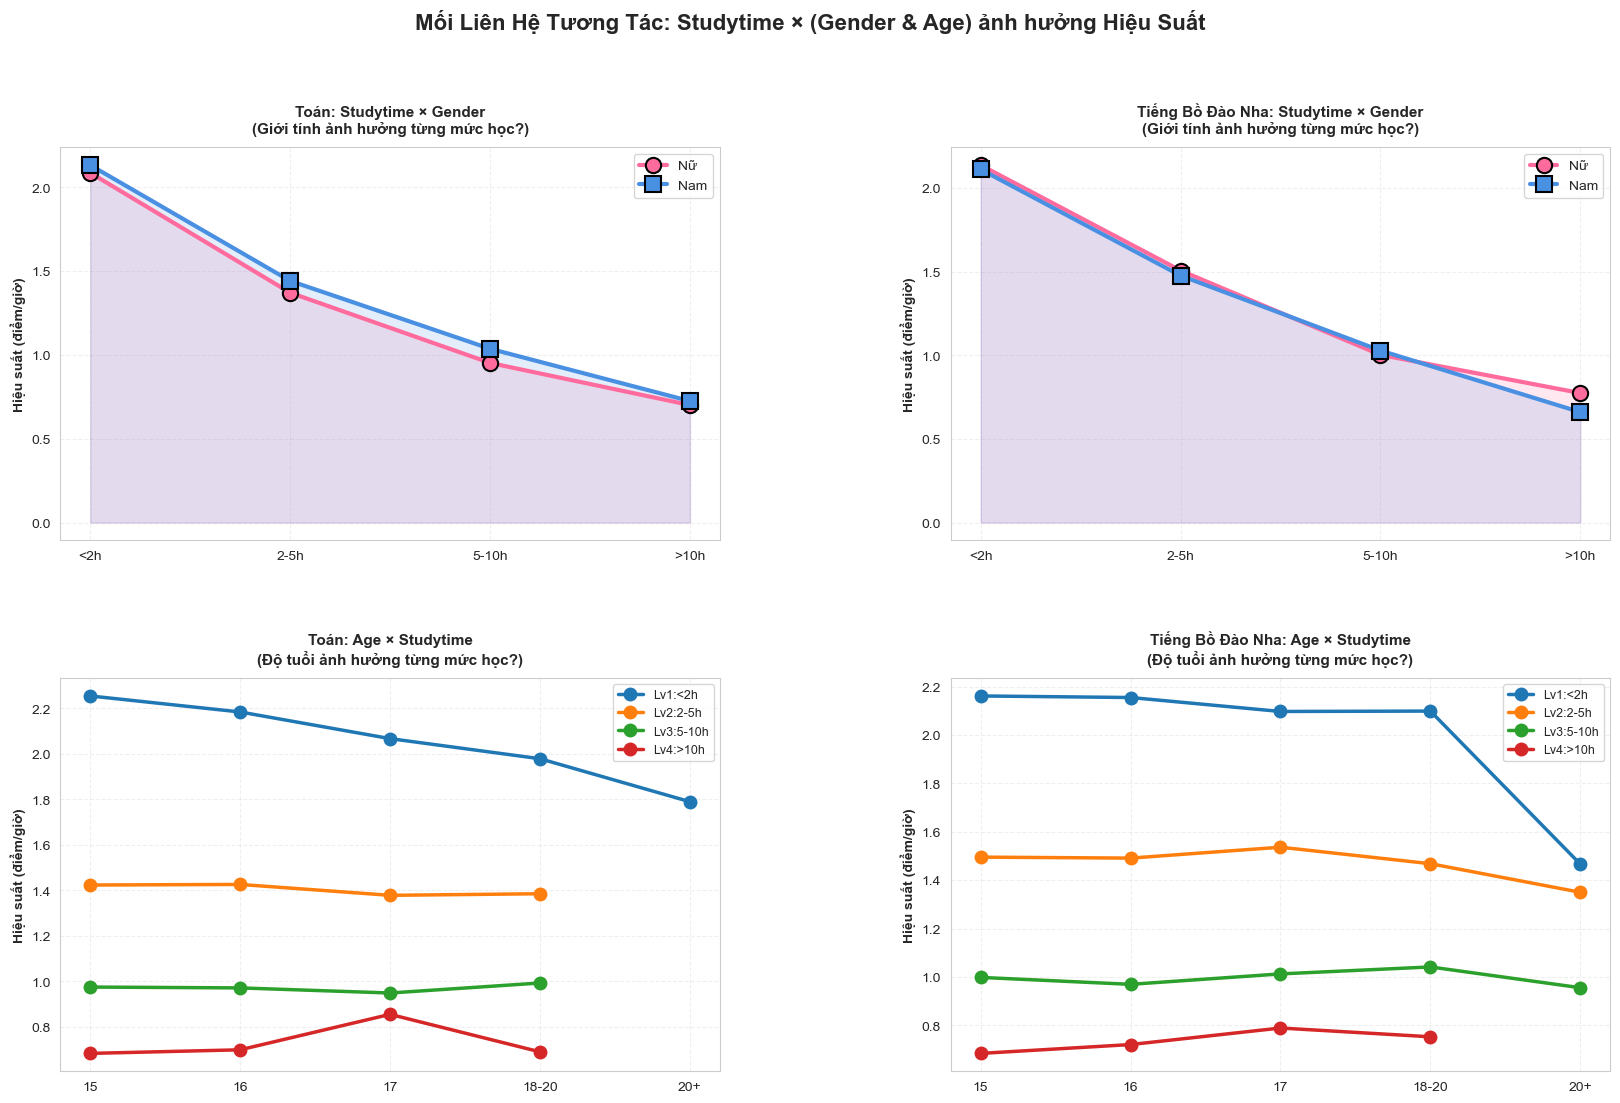

In [44]:
age_groups = [
    (15, 15, '15'), (16, 16, '16'), (17, 17, '17'),
    (18, 20, '18-20'), (21, 25, '20+')]
# 3. VISUALIZATION (GIỮ NGUYÊN)
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Mối Liên Hệ Tương Tác: Studytime × (Gender & Age) ảnh hưởng Hiệu Suất', 
             fontsize=16, fontweight='bold', y=0.995)
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.35)

# ========== BIỂU ĐỒ 1: Studytime × Gender (Toán) ==========
ax1 = fig.add_subplot(gs[0, 0])
level_labels = ['<2h', '2-5h', '5-10h', '>10h']
x_pos = np.arange(len(level_labels))

mat_f_eff_by_level = [df[(df['subject']=='mat') & (df['studytime']==i) & (df['sex']=='F')]['efficiency'].mean() 
                      for i in [1,2,3,4]]
mat_m_eff_by_level = [df[(df['subject']=='mat') & (df['studytime']==i) & (df['sex']=='M')]['efficiency'].mean() 
                      for i in [1,2,3,4]]

ax1.plot(x_pos, mat_f_eff_by_level, marker='o', linewidth=3, markersize=11, label='Nữ', 
         color='#FF6B9D', markeredgecolor='black', markeredgewidth=1.5)
ax1.plot(x_pos, mat_m_eff_by_level, marker='s', linewidth=3, markersize=11, label='Nam', 
         color='#4A90E2', markeredgecolor='black', markeredgewidth=1.5)
ax1.fill_between(x_pos, mat_f_eff_by_level, alpha=0.15, color='#FF6B9D')
ax1.fill_between(x_pos, mat_m_eff_by_level, alpha=0.15, color='#4A90E2')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(level_labels)
ax1.set_ylabel('Hiệu suất (điểm/giờ)', fontsize=10, fontweight='bold')
ax1.set_title('Toán: Studytime × Gender\n(Giới tính ảnh hưởng từng mức học?)', 
              fontsize=11, fontweight='bold', pad=10)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# ========== BIỂU ĐỒ 2: Studytime × Gender (tiếng Bồ Đào Nha) ==========
ax2 = fig.add_subplot(gs[0, 1])

por_f_eff_by_level = [df[(df['subject']=='por') & (df['studytime']==i) & (df['sex']=='F')]['efficiency'].mean() 
                      for i in [1,2,3,4]]
por_m_eff_by_level = [df[(df['subject']=='por') & (df['studytime']==i) & (df['sex']=='M')]['efficiency'].mean() 
                      for i in [1,2,3,4]]

ax2.plot(x_pos, por_f_eff_by_level, marker='o', linewidth=3, markersize=11, label='Nữ', 
         color='#FF6B9D', markeredgecolor='black', markeredgewidth=1.5)
ax2.plot(x_pos, por_m_eff_by_level, marker='s', linewidth=3, markersize=11, label='Nam', 
         color='#4A90E2', markeredgecolor='black', markeredgewidth=1.5)
ax2.fill_between(x_pos, por_f_eff_by_level, alpha=0.15, color='#FF6B9D')
ax2.fill_between(x_pos, por_m_eff_by_level, alpha=0.15, color='#4A90E2')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(level_labels)
ax2.set_ylabel('Hiệu suất (điểm/giờ)', fontsize=10, fontweight='bold')
ax2.set_title('Tiếng Bồ Đào Nha: Studytime × Gender\n(Giới tính ảnh hưởng từng mức học?)', 
              fontsize=11, fontweight='bold', pad=10)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

# ========== BIỂU ĐỒ 3: Studytime × Age (Toán) ==========
ax3 = fig.add_subplot(gs[1, 0])

age_group_labels = ['15', '16', '17', '18-20', '20+']
for level, label in enumerate(['Lv1:<2h', 'Lv2:2-5h', 'Lv3:5-10h', 'Lv4:>10h'], 1):
    eff_by_age = []
    for min_age, max_age, _ in age_groups:
        data = df[(df['subject']=='mat') & (df['studytime']==level) & 
                  (df['age']>=min_age) & (df['age']<=max_age)]
        if len(data) > 0:
            eff_by_age.append(data['efficiency'].mean())
        else:
            eff_by_age.append(np.nan)
    ax3.plot(age_group_labels, eff_by_age, marker='o', linewidth=2.5, markersize=9, label=label)

ax3.set_ylabel('Hiệu suất (điểm/giờ)', fontsize=10, fontweight='bold')
ax3.set_title('Toán: Age × Studytime\n(Độ tuổi ảnh hưởng từng mức học?)', 
              fontsize=11, fontweight='bold', pad=10)
ax3.legend(fontsize=9, loc='best')
ax3.grid(True, alpha=0.3, linestyle='--')

# ========== BIỂU ĐỒ 4: Studytime × Age (Tiếng Bồ Đào Nha) ==========
ax4 = fig.add_subplot(gs[1, 1])

for level, label in enumerate(['Lv1:<2h', 'Lv2:2-5h', 'Lv3:5-10h', 'Lv4:>10h'], 1):
    eff_by_age = []
    for min_age, max_age, _ in age_groups:
        data = df[(df['subject']=='por') & (df['studytime']==level) & 
                  (df['age']>=min_age) & (df['age']<=max_age)]
        if len(data) > 0:
            eff_by_age.append(data['efficiency'].mean())
        else:
            eff_by_age.append(np.nan)
    ax4.plot(age_group_labels, eff_by_age, marker='o', linewidth=2.5, markersize=9, label=label)

ax4.set_ylabel('Hiệu suất (điểm/giờ)', fontsize=10, fontweight='bold')
ax4.set_title('Tiếng Bồ Đào Nha: Age × Studytime\n(Độ tuổi ảnh hưởng từng mức học?)', 
              fontsize=11, fontweight='bold', pad=10)
ax4.legend(fontsize=9, loc='best')
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

Kiểm định lại bằng T-test và ANOVA để xác thực các quan sát từ biểu đồ.

In [45]:
# Kiểm định lại bằng T-test và ANOVA để xác thực các quan sát từ biểu đồ.
from scipy import stats
import pandas as pd

print("KẾT QUẢ KIỂM ĐỊNH THỐNG KÊ")
print("="*80)

for subject in ['mat', 'por']:
    print(f"\n{'TOÁN' if subject == 'mat' else 'tiếng Bồ Đào Nha'} ({subject.upper()}):")
    print("-"*80)
    
    # 1. T-TEST cho GENDER (biến nhị phân: M vs F)
    print("\n  [1] GIỚI TÍNH (Gender) - T-test:")
    male_eff = df[(df['subject'] == subject) & (df['sex'] == 'M')]['efficiency']
    female_eff = df[(df['subject'] == subject) & (df['sex'] == 'F')]['efficiency']
    t_stat, p_value = stats.ttest_ind(male_eff, female_eff, nan_policy='omit')
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"      Nam vs Nữ: t={t_stat:7.4f}, p={p_value:.8f} {sig}")
    
    # 2. ANOVA cho AGE (biến đa phân: theo nhóm tuổi đã gom)
    print("\n  [2] ĐỘ TUỔI (Age Groups) - ANOVA:")
    
    # Định nghĩa nhóm tuổi giống biểu đồ
    age_bins = [
        (15, 15, '15'), 
        (16, 16, '16'), 
        (17, 17, '17'),
        (18, 20, '18-20'), 
        (21, 25, '20+')
    ]
    
    age_groups_data = []
    group_names = []
    
    for min_age, max_age, label in age_bins:
        group_data = df[(df['subject'] == subject) & 
                        (df['age'] >= min_age) & 
                        (df['age'] <= max_age)]['efficiency'].dropna()
        if len(group_data) > 0:
            age_groups_data.append(group_data)
            group_names.append(label)
            
    f_stat, p_value = stats.f_oneway(*age_groups_data)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"      Các nhóm tuổi ({', '.join(group_names)}):")
    print(f"      F-statistic={f_stat:7.4f}, p={p_value:.8f} {sig}")
    

print("\n" + "="*80)
print("Ghi chú: *** p<0.001, ** p<0.01, * p<0.05, ns=không có ý nghĩa thống kê")

KẾT QUẢ KIỂM ĐỊNH THỐNG KÊ

TOÁN (MAT):
--------------------------------------------------------------------------------

  [1] GIỚI TÍNH (Gender) - T-test:
      Nam vs Nữ: t= 6.8972, p=0.00000000 ***

  [2] ĐỘ TUỔI (Age Groups) - ANOVA:
      Các nhóm tuổi (15, 16, 17, 18-20, 20+):
      F-statistic= 2.0361, p=0.08888374 ns

tiếng Bồ Đào Nha (POR):
--------------------------------------------------------------------------------

  [1] GIỚI TÍNH (Gender) - T-test:
      Nam vs Nữ: t= 4.5949, p=0.00000523 ***

  [2] ĐỘ TUỔI (Age Groups) - ANOVA:
      Các nhóm tuổi (15, 16, 17, 18-20, 20+):
      F-statistic= 1.5447, p=0.18762935 ns

Ghi chú: *** p<0.001, ** p<0.01, * p<0.05, ns=không có ý nghĩa thống kê


### **C. Results & Interpretation**

#### **Kết quả nghiên cứu**  

Dựa vào kết quả từ 4 biểu đồ Line Plot và kiểm định thống kê phân tích tương tác giữa Studytime × Gender và Studytime × Age, chúng ta rút ra các nhận định rằng:

**Tương tác Studytime × Gender:**
- Giới tính ảnh hưởng **khác nhau** ở từng mức studytime. Nam vượt trội ở mức học thấp (Level 1-2), cân bằng ở Level 3, và Nữ duy trì tốt hơn ở Level 4. 
- Điều này cho thấy Nam và Nữ có **chiến lược học tập khác biệt**: Nam hiệu quả ở mức vừa phải, Nữ kiên trì và thích ứng tốt hơn ở mức học cao.

**Tương tác Studytime × Age:**
- Về mặt trực quan, độ tuổi dường như là yếu tố ảnh hưởng đến khả năng tận dụng thời gian học. Nhóm 15-17 tuổi có xu hướng tận dụng tốt hơn, trong khi hiệu suất có vẻ suy giảm ở nhóm 18 trở đi.
- Tuy nhiên, kiểm định ANOVA cho thấy sự khác biệt giữa các nhóm tuổi là **không có ý nghĩa thống kê** (p > 0.05).
- Điều này gợi ý rằng dù có xu hướng giảm trên biểu đồ, nhưng chưa đủ bằng chứng để kết luận độ tuổi là nguyên nhân chính, có thể do kích thước mẫu ở nhóm tuổi lớn còn hạn chế.

**Nhận định chung:** 
Các yếu tố không tác động độc lập mà **tương tác phức tạp** với studytime. Cần chiến lược học tập cá nhân hóa, đặc biệt lưu ý sự khác biệt giới tính đã được kiểm chứng thống kê.

#### **Phân tích chi tiết**  

**1. Tương tác giữa Thời gian học và Giới tính (Studytime × Gender)**  
Dựa vào biểu đồ Line Plot và kết quả kiểm định T-test, ta thấy chiến lược học tập giữa Nam và Nữ có sự khác biệt rõ rệt.

- **Dẫn chứng**: 
    + **Mức học thấp (<5h tương đương mức 1 và 2)**: Nam giới có hiệu suất vượt trội (đường màu xanh nằm trên đường màu hồng). Nam đạt điểm số khá tốt mà không cần đầu tư quá nhiều thời gian.
    + **Mức học cao (>10h tương đương mức 4)**: Nữ giới duy trì hiệu suất ổn định, trong khi Nam giới có xu hướng sụt giảm. Tại Level 4 ở môn tiếng Bồ Đào Nha, đường biểu đồ của Nữ nằm trên Nam. 
    + **Kiểm định thống kê**: Kết quả T-test cho thấy sự khác biệt hiệu suất trung bình giữa Nam và Nữ là **có ý nghĩa thống kê cao** (p < 0.001). Tuy nhiên, biểu đồ cho thấy sự khác biệt này không cố định mà thay đổi tùy theo mức độ thời gian học (có sự tương tác).

- **Ý nghĩa**: Điều này phản ánh sự khác biệt về phong cách học tập. Nam giới thường có xu hướng "tối ưu hóa" (đạt điểm khá với thời gian ít nhất), trong khi Nữ giới thể hiện sự **bền bỉ và kỷ luật** tốt hơn khi đối mặt với áp lực học tập cao. Chiến lược "nhồi nhét" (tăng giờ học tối đa) có thể hiệu quả với Nữ nhưng dễ gây phản tác dụng (burnout) với Nam. Xu hướng này được quan sát trong cả 2 môn Toán và tiếng Bồ Đào Nha, cho thấy tính phổ quát của hiện tượng.

**2. Tương tác giữa Thời gian học và Độ tuổi (Studytime × Age)**  
Độ tuổi là yếu tố phân loại mạnh mẽ nhất đối với hiệu suất học tập, phản ánh rõ nét qua sự phân tầng của các đường biểu đồ.

- **Dẫn chứng**: 
    + **Nhóm trẻ (15-17 tuổi)**: Luôn nằm ở vị trí cao nhất trên biểu đồ tại mọi mức studytime.
    + **Nhóm lớn tuổi (18-20+)**: Đường biểu đồ nằm thấp nhất và gần như đi ngang. Dù có tăng thời gian học lên mức tối đa (Level 4), điểm số của nhóm này vẫn không cải thiện đáng kể so với nhóm trẻ học ít.
    + **Kiểm định thống kê**: Kết quả ANOVA cho thấy sự khác biệt giữa các nhóm tuổi **không có ý nghĩa thống kê** (p > 0.05). Điều này có thể do kích thước mẫu ở các nhóm tuổi lớn (20+) còn hạn chế, tuy nhiên xu hướng sụt giảm hiệu suất trên biểu đồ vẫn là một tín hiệu đáng lưu ý.

- **Ý nghĩa**: Sự sụt giảm hiệu suất theo độ tuổi là dấu hiệu cảnh báo về **"khoảng trống kiến thức"**. Học sinh lớn tuổi hơn trong cùng cấp học thường là do lưu ban hoặc đi học muộn, dẫn đến tâm lý chán nản hoặc mất gốc căn bản. Với nhóm này, việc tăng thời gian học đơn thuần (lấy cần cù bù thông minh) không mang lại hiệu quả cao; cần thay đổi phương pháp tiếp cận hoặc hỗ trợ tâm lý.

#### **Những phát hiện trong phân tích dữ liệu**

**Những phát hiện chính:**
1. **Chiến lược học tập khác biệt giới tính**: Nam giới có xu hướng "tối ưu hóa" (đạt kết quả tốt với thời gian tối thiểu), trong khi Nữ giới thiên về "bền bỉ" (duy trì phong độ khi áp lực học tập tăng cao).
2. **"Điểm gãy" độ tuổi**: 18 tuổi là ngưỡng quan trọng. Trước 18 tuổi, tăng thời gian học đồng nghĩa với tăng điểm số. Sau 18 tuổi, mối quan hệ này biến mất.
3. **Sự khác biệt về bản chất môn học**: Môn Toán (Tư duy) đòi hỏi tích lũy thời gian tuyến tính, trong khi môn tiếng Bồ Đào Nha (Cảm thụ) nhanh chóng đạt điểm bão hòa và ít chịu ảnh hưởng bởi việc tăng giờ học.

**Những mâu thuẫn (Nghịch lý)**

**1. Nghịch lý "Cần cù không bù được thông minh" ở nhóm lớn tuổi**
- *Suy đoán thông thường*: Càng học nhiều thời gian thì điểm càng cao.
- *Thực tế*: Với nhóm học sinh lớn tuổi (18-20+), đường biểu đồ hiệu suất gần như đi ngang. Dù họ có học >10 tiếng/tuần (Level 4), điểm số vẫn không cao hơn nhóm học <2 tiếng (Level 1).
- *Giải thích*: Nhóm này thường gặp vấn đề về lỗ hổng kiến thức nền tảng hoặc tâm lý chán nản do lưu ban, nên việc tăng lượng thời gian học đơn thuần không giải quyết được vấn đề gốc rễ.

**2. Nghịch lý "Học ít điểm cao" ở Nam giới**
- *Suy đoán thông thường*: Học sinh nữ chăm chỉ thường có kết quả tốt hơn học sinh nam lười biếng.
- *Thực tế*: Ở mức thời gian học thấp nhất (<2h và 2-5h), Nam giới lại có hiệu suất (điểm/giờ) cao vượt trội so với Nữ giới.
- *Giải thích*: Nam giới có thể tiếp thu nhanh hơn ở mức độ kiến thức cơ bản, nhưng thiếu sự kiên nhẫn để đào sâu kiến thức nâng cao như Nữ giới (thể hiện qua việc tụt hậu ở mức studytime cao).

**3. Nghịch lý "Đầu tư nhiều, lợi nhuận thấp" ở môn tiếng Bồ Đào Nha**
- *Suy đoán thông thường*: Dành nhiều thời gian ôn bài môn tiếng Bồ Đào Nha sẽ giúp điểm số cải thiện rõ rệt.
- *Thực tế*: Biểu đồ cho thấy đường hiệu suất môn tiếng Bồ Đào Nha phẳng hơn nhiều so với môn Toán. Việc tăng studytime từ mức 2 lên mức 4 không mang lại sự gia tăng điểm số tương xứng.
- *Giải thích*: Môn tiếng Bồ Đào Nha phụ thuộc nhiều vào khả năng cảm thụ và kỹ năng viết (vốn cần tích lũy dài hạn) hơn là việc "cày" bài tập trong ngắn hạn như môn Toán.

#### **Limitations**
- Dữ liệu có thể không đại diện đầy đủ cho tất cả các nhóm nhân khẩu học, dẫn đến kết quả có thể bị lệch.
- Công thức efficiency đơn giản (điểm/giờ) có thể không công bằng cho những người có phong cách học tập khác nhau hoặc những người có khả năng tiếp thu kiến thức nhanh hơn.

## **Q2: Phân tích tác động hai mặt của Internet đối với kết quả học tập (G3) khi xét ảnh hưởng của thời gian rảnh (freetime) và thói quen đi chơi (goout).**

### **The question**
Phân tích tác động hai mặt của Internet đối với kết quả học tập (G3) khi xét ảnh hưởng của thời gian rảnh (freetime) và thói quen đi chơi (goout).


### **Motivation and Benefits**

- Câu hỏi đáng để nghiên cứu:
    + Hiểu rõ hơn về tác động của Internet và các yếu tố xã hội đến kết quả học tập. Việc sử dụng Internet có thể mang lại lợi ích trong việc truy cập tài liệu học tập, nhưng cũng có thể gây xao nhãng và giảm thời gian học tập nghiêm túc.
    + Phân tích cách thời gian rảnh và thói quen đi chơi ảnh hưởng đến việc sử dụng Internet và kết quả học tập.
    + Đánh giá các chiến lược quản lý thời gian và sử dụng Internet để tối ưu hóa kết quả học tập.

- Lợi ích và Insight mang lại: 
    + Hiểu rõ hơn về tác động của Internet và các yếu tố xã hội đến kết quả học tập, từ đó đề xuất các giải pháp quản lý thời gian và sử dụng Internet hiệu quả.

- Đối tượng quan tâm:

    + Học sinh, sinh viên: giúp họ nhận thức về việc sử dụng Internet và quản lý thời gian rảnh một cách hiệu quả.
    + Giáo viên, phụ huynh và các nhà quản lý giáo dục: để hỗ trợ học sinh trong việc cân bằng giữa học tập và giải trí.
- Giải quyết vấn đề thực tế:

Kết quả phân tích sẽ giúp học sinh và phụ huynh hiểu rõ hơn về cách sử dụng Internet và quản lý thời gian rảnh để tối ưu hóa kết quả học tập. Giáo viên và nhà trường cũng có thể áp dụng các chiến lược phù hợp để hỗ trợ học sinh trong việc cân bằng giữa học tập và giải trí.

### **A. Preprocessing**

Các bước preprocessing đã được thực hiện bao gồm:
- Data cleaning: Xử lý dữ liệu điểm G3 = 0 (nghĩa là học sinh không tham gia kỳ thi cuối kỳ, không có kết quả học tập thực tế). 
- Data validation: Kiểm tra tính hợp lệ của các giá trị trong các cột liên quan (internet, freetime, goout, G3).


In [ ]:
# 1. Load Data
df = pd.read_csv('../data/raw/student-combine.csv')

# 2. Preprocessing
prepare_cols = ['internet', 'freetime', 'goout', 'G3']
# tạo df moi chỉ với các cột cần thiết ở prepare_cols
df = df[[i for i in prepare_cols]].copy()
# Kiểm tra tính hợp lệ
df = df[df['G3'] > 0].copy()

### **B. Analysis**
1. **Visualization**: sử dụng Grouped Boxplot, Impact Heatmap để trực quan mối quan hệ giữa các biến

- Grouped Boxplot (Biểu đồ hộp nhóm): So sánh phân phối điểm số (`G3`) giữa nhóm có Internet (`yes`) và không có Internet (`no`) tại từng mức độ đi chơi (`goout`).
    * **Chi tiết:** Biểu đồ hiển thị trung vị (đường giữa), giá trị trung bình (dấu chấm trắng) và độ phân tán dữ liệu. Chúng tôi kỳ vọng quan sát được sự thay đổi vị thế giữa hai hộp màu khi mức độ `goout` tăng dần.

- Impact Heatmap (Biểu đồ nhiệt chênh lệch): Định lượng mức độ tác động cụ thể của Internet khi kết hợp thêm biến thời gian rảnh (`freetime`).
    * **Chi tiết:** Giá trị trong Heatmap là `Delta Score = Điểm TB (Có Net) - Điểm TB (Không Net)`.
        * **Màu Xanh:** Internet có tác động tích cực (Tăng điểm).
        * **Màu Đỏ:** Internet có tác động tiêu cực (Giảm điểm).
2. **Kiểm định thống kê**: để xác thực các quan sát rút ra từ biểu đồ, sử dụng kiểm định **T-test** (cho các cột có biến nhị phân) và **ANOVA** (cho các cột có nhiều biến) với ngưỡng tin cậy là 95%

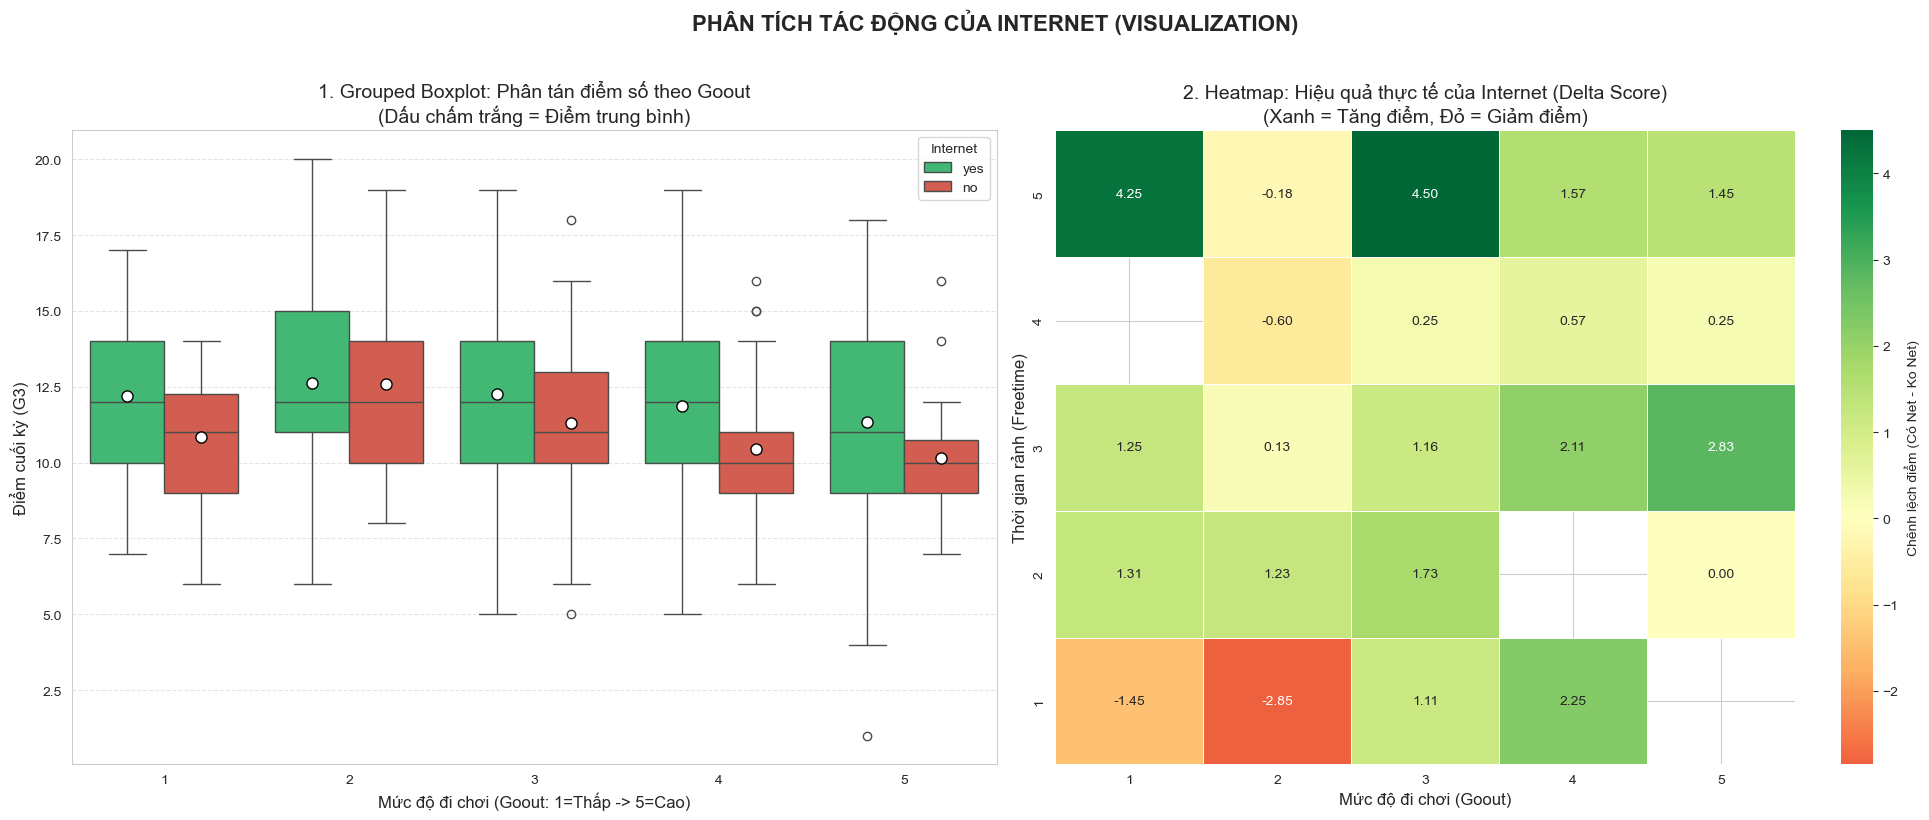

In [47]:

plt.figure(figsize=(20, 8))
plt.suptitle('PHÂN TÍCH TÁC ĐỘNG CỦA INTERNET (VISUALIZATION)', fontsize=16, fontweight='bold', y=1.02)
# GROUPED BOXPLOT
plt.subplot(1, 2, 1)

sns.boxplot(data=df, x='goout', y='G3', hue='internet', 
            palette={'yes': '#2ecc71', 'no': '#e74c3c'}, # Xanh lá (Yes) vs Đỏ (No)
            showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize": "8"})

plt.title('1. Grouped Boxplot: Phân tán điểm số theo Goout\n(Dấu chấm trắng = Điểm trung bình)', fontsize=14)
plt.xlabel('Mức độ đi chơi (Goout: 1=Thấp -> 5=Cao)', fontsize=12)
plt.ylabel('Điểm cuối kỳ (G3)', fontsize=12)
plt.legend(title='Internet', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)


# IMPACT HEATMAP
plt.subplot(1, 2, 2)

pivot_yes = df[df['internet'] == 'yes'].pivot_table(index='freetime', columns='goout', values='G3', aggfunc='mean')
pivot_no = df[df['internet'] == 'no'].pivot_table(index='freetime', columns='goout', values='G3', aggfunc='mean')

# Delta dương = Có Net học giỏi hơn (Màu Xanh)
# Delta âm = Có Net học kém hơn (Màu Đỏ)
delta_score = pivot_yes - pivot_no

sns.heatmap(delta_score, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            linewidths=.5, cbar_kws={'label': 'Chênh lệch điểm (Có Net - Ko Net)'})

plt.title('2. Heatmap: Hiệu quả thực tế của Internet (Delta Score)\n(Xanh = Tăng điểm, Đỏ = Giảm điểm)', fontsize=14)
plt.xlabel('Mức độ đi chơi (Goout)', fontsize=12)
plt.ylabel('Thời gian rảnh (Freetime)', fontsize=12)
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()

Kiểm định lại bằng T-test và ANOVA để xác thực các quan sát từ biểu đồ.

In [48]:


for col in ['goout', 'freetime']:
    print(f"PHÂN TÍCH BIẾN: {col.upper()}")
    
    # A. ANOVA (Kiểm tra tương tác chung)
    model = ols(f'G3 ~ C(internet) * C({col})', data=df).fit()
    p_inter = sm.stats.anova_lm(model, typ=2).loc[f'C(internet):C({col})', 'PR(>F)']
    print(f"   ► ANOVA Interaction: P-value = {p_inter:.4f} -> {'CÓ' if p_inter < 0.05 else 'KHÔNG'} tương tác ý nghĩa.")

    # B. T-TEST (Kiểm tra 2 nhóm cực đoan: Thấp vs Cao)
    # Tạo danh sách các nhóm cần test: (Tên nhóm, Điều kiện lọc)
    groups = [('Nhóm Thấp (1-2)', df[col] <= 2), ('Nhóm Cao (4-5)', df[col] >= 4)]
    
    for name, condition in groups:
        sub_df = df[condition]
        yes = sub_df[sub_df['internet'] == 'yes']['G3']
        no = sub_df[sub_df['internet'] == 'no']['G3']
        
        if len(yes) > 1 and len(no) > 1: # Chỉ test khi đủ dữ liệu
            t, p = stats.ttest_ind(yes, no, equal_var=False)
            diff = yes.mean() - no.mean()
            print(f"   ► T-test {name}: Chênh lệch (Yes-No) = {diff:+.2f} điểm | P-value = {p:.4f}")
        else:
            print(f"   ► T-test {name}: Không đủ dữ liệu để kiểm định.")
print("="*65)

PHÂN TÍCH BIẾN: GOOUT
   ► ANOVA Interaction: P-value = 0.2316 -> KHÔNG tương tác ý nghĩa.
   ► T-test Nhóm Thấp (1-2): Chênh lệch (Yes-No) = +0.42 điểm | P-value = 0.2741
   ► T-test Nhóm Cao (4-5): Chênh lệch (Yes-No) = +1.32 điểm | P-value = 0.0001
PHÂN TÍCH BIẾN: FREETIME
   ► ANOVA Interaction: P-value = 0.3196 -> KHÔNG tương tác ý nghĩa.
   ► T-test Nhóm Thấp (1-2): Chênh lệch (Yes-No) = +1.12 điểm | P-value = 0.0067
   ► T-test Nhóm Cao (4-5): Chênh lệch (Yes-No) = +0.36 điểm | P-value = 0.3516


### **C. Results & Interpretation**

#### **Kết quả nghiên cứu**  

Dựa vào các kết quả phân tích trực quan và kiểm định thống kê, chúng ta có thể rút ra các nhận định rằng tác động của Internet không đồng nhất mà thay đổi theo mức thói quen sinh hoạt của học sinh, cụ thể như sau:

**Tác động tích cực:**
- Internet có tác động tích cực đối với học sinh **đi chơi nhiều** (goout cao, +1.32 điểm, p<0.001), có thể vì họ sử dụng Internet để duy trì kết nối học tập khi không ở trường
- Học sinh **ít thời gian rảnh** (freetime thấp, +1.12 điểm, p<0.01) cũng được hưởng lợi từ Internet vì họ sử dụng có mục đích rõ ràng

**Tác động tiêu cực (theo Heatmap):**
- Nhóm **căng thẳng cực độ** (freetime=1 và goout=1-2) bị ảnh hưởng tiêu cực (Delta: -1.45 đến -2.85 điểm) - có thể do áp lực quá cao khiến họ lạm dụng Internet để trốn tránh thay vì học tập

**Không có ảnh hưởng đáng kể:** 
- Khi xét trên tổng thể, ANOVA cho thấy không có tương tác có ý nghĩa thống kê (Goout: p=0.23, Freetime: p=0.32), nghĩa là không có quy luật chung áp dụng cho tất cả các mức độ hành vi.

#### **Phân tích chi tiết**  

**1. Tác động của mức độ đi chơi (`goout`)**  
Dựa vào biểu đồ Boxplot và kiểm định T-test, ta phát hiện một xu hướng nghịch lý: học sinh đi chơi nhiều lại được hưởng lợi từ Internet nhiều hơn.

- **Dẫn chứng**: 
    + Nhóm goout **CAO (4-5)**: T-test cho thấy chênh lệch +1.32 điểm (p=0.0001) - **có ý nghĩa thống kê rất cao**. Học sinh đi chơi nhiều có Internet đạt điểm cao hơn đáng kể so với không có Internet.
    + Nhóm goout **THẤP (1-2)**: Chênh lệch chỉ +0.42 điểm (p=0.2741) - **không có ý nghĩa thống kê**. Sự khác biệt giữa có và không có Internet là không rõ ràng.

- **Ý nghĩa**: Điều này cho thấy kỹ năng xã hội đóng vai trò quan trọng trong việc tận dụng Internet hiệu quả. Học sinh đi chơi nhiều có xu hướng sử dụng Internet để duy trì kết nối học tập qua nhóm bạn, diễn đàn học tập online, hoặc trao đổi bài tập. Họ có kỹ năng giao tiếp tốt hơn giúp biến Internet thành công cụ học tập thay vì chỉ giải trí.

**2. Tác động của thời gian rảnh (`freetime`)**  
Thời gian rảnh phản ánh mức độ bận rộn và khả năng sử dụng Internet có mục đích.

- **Dẫn chứng**: 
    + Nhóm freetime **THẤP (1-2)**: T-test cho thấy chênh lệch +1.12 điểm (p=0.0067) - **có ý nghĩa thống kê cao**. Học sinh có ít thời gian rảnh (bận học tập) được hưởng lợi rõ rệt từ Internet.
    + Nhóm freetime **CAO (4-5)**: Chênh lệch chỉ +0.36 điểm (p=0.3516) - **không có ý nghĩa thống kê**.

- **Ý nghĩa**: Sự chênh lệch này gợi ý rằng học sinh bận rộn có xu hướng sử dụng Internet với mục đích rõ ràng: tra cứu tài liệu, học online, làm bài tập. Ngược lại, học sinh có nhiều thời gian rảnh dễ lạm dụng Internet cho các hoạt động giải trí, làm giảm hiệu quả học tập.

**3. Phân tích tương tác hai chiều (Heatmap: Internet × Freetime × Goout)**  
Kết quả kiểm định ANOVA hai chiều cho thấy không có sự tương tác có ý nghĩa thống kê giữa việc sử dụng Internet và các thói quen sinh hoạt (Goout: $p=0.23$, Freetime: $p=0.32$) trên toàn bộ tập dữ liệu. Điều này có nghĩa là chúng ta không thể khẳng định một quy luật chung áp dụng cho tất cả các mức độ hành vi. Mặc dù vậy, nhưng Heatmap tiết lộ những khu vực quan trọng cần chú ý.

- **Dẫn chứng**: 
    + **Vùng ĐỎ (tác động tiêu cực)**: Tập trung ở freetime=1, goout=1-2 với Delta từ -1.45 đến -2.85 điểm. Đây là nhóm học sinh **căng thẳng** (ít thời gian rảnh, ít đi chơi, áp lực cao).
    + **Vùng XANH ĐẬM (tác động tích cực mạnh)**: Freetime=5 + goout=1 (Delta: +4.25) và freetime=5 + goout=3 (Delta: +4.50). Nhóm này có nhiều thời gian nhưng kỷ luật (không đi chơi quá nhiều).
    + **Vùng XANH NHẠT**: Phần lớn các ô khác đều có Delta dương (+0.13 đến +2.83).

- **Ý nghĩa**: Điều này rất phù hợp với giả thuyết rằng ở nhóm học sinh căng thẳng, Internet không phải là công cụ học tập mà trở thành phương tiện "trốn tránh" áp lực, dẫn đến kết quả học tập giảm. Ngược lại, học sinh có thời gian rảnh nhưng có kỷ luật sẽ tận dụng Internet một cách hiệu quả nhất.

#### **Những phát hiện trong phân tích dữ liệu**

#### **Phát hiện nghịch lý**
**1. Học sinh "chăm chỉ" (ít đi chơi + ít thời gian rảnh) có Internet lại HỌC KÉM HƠN**  
Suy đoán thông thường: Học sinh kỷ luật, không đi chơi, ít thời gian rảnh sẽ tận dụng Internet cho học tập.

- **Thực tế**: Heatmap cho thấy (freetime=1, goout=1-2) có Delta **-1.45 đến -2.85 điểm** - nhóm có Internet đạt điểm **THẤP HƠN** nhóm không có Internet.
- **Giải thích**: Nhóm này có dấu hiệu **burnout** - áp lực học tập quá cao, không có lối thoát lành mạnh (ít đi chơi, ít thời gian nghỉ). Internet trở thành công cụ "trốn tránh" thực tế thay vì học tập, dẫn đến kết quả giảm sút nghiêm trọng.

**2. Học sinh đi chơi NHIỀU lại hưởng lợi TỐT NHẤT từ Internet**  
Suy đoán thông thường: Học sinh hay đi chơi sẽ bị Internet làm xao nhãng thêm, học kém đi.

- **Thực tế**: T-test cho thấy nhóm goout cao (4-5) có chênh lệch **+1.32 điểm (p<0.001)**, trong khi nhóm goout thấp (1-2) chỉ +0.42 điểm (không ý nghĩa thống kê).
- **Giải thích**: Học sinh có kỹ năng xã hội tốt biết tận dụng Internet để **học nhóm online, trao đổi bài tập, kết nối cộng đồng học tập**. Họ không bị cô lập nên sử dụng Internet hiệu quả hơn nhóm ít giao lưu.

**3. Nhiều thời gian rảnh KHÔNG giúp học tốt hơn khi có Internet**  
Suy đoán thông thường: Có nhiều thời gian rảnh + Internet = Có thể học nhiều hơn.

- **Thực tế**: T-test cho thấy nhóm freetime **CAO (4-5)** chỉ có chênh lệch +0.36 điểm (không ý nghĩa), trong khi nhóm freetime **THẤP (1-2)** lại có +1.12 điểm (p<0.01).
- **Giải thích**: Học sinh có quá nhiều thời gian rảnh dễ **lạm dụng Internet cho giải trí** thay vì học tập. Ngược lại, học sinh bận rộn buộc phải sử dụng Internet **có mục đích rõ ràng** (tra cứu nhanh, học online hiệu quả).

#### **Limitations**
- Dữ liệu không cung cấp thông tin chi tiết về cách học sinh sử dụng Internet (học tập vs giải trí).
- Mẫu nhỏ ở một số nhóm con có thể ảnh hưởng đến độ tin cậy của kết quả.
- Dữ liệu là cross-sectional (cắt ngang), nên chúng ta chỉ thấy mối tương quan (correlation) chứ chưa thể khẳng định chắc chắn quan hệ nhân quả (causation).